In [1]:
import os
import sys
import h5py
import shutil
import csv
import pandas as pd
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import tensorflow.keras.backend as K
from esutil import wcsutil
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras
import random
from astropy.visualization import (ZScaleInterval, ImageNormalize)

In [2]:
#define useful directories

scratch = os.path.expandvars('$HOME') +'/projects/rrg-kyi/astro/cfis/'
h5_names = ['Dataset_run2_'+ str(i+1) + '.h5' for i in range(4)]

hf_1 = h5py.File(scratch+ h5_names[0], "r")

In [27]:
src =  os.path.expandvars('$HOME') +'/projects/rrg-kyi/astro/cfis/' + 'Dataset_run2_1.h5'
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
shutil.copy2(src, dest)

'/localscratch/anahoban.21832691.0/Dataset_run2_1.h5'

In [3]:
hf_1 = h5py.File(scratch+ h5_names[0], "r")

Dataset_run2_1.h5  LSB/                         mastercat_run2.csv
Dataset_run2_2.h5  W3/                          mastercat_run2_1.csv
Dataset_run2_3.h5  autoencoder_full_dataset_w/  mastercat_run2_3.csv
Dataset_run2_4.h5  class_dataset/               mastercat_run2_4.csv


In [4]:
keys = hf_1.keys()

In [5]:
#corresponding master catalogue
df =  pd.read_csv(scratch + 'mastercat_run2.csv')
keys =  df["tile"].astype(str) + '_' + df["index"].str.slice_replace(stop=1, repl='')

### Preprocessing functions

In [6]:
import random
def rotation(tensor):
    rand = random.random()
    if rand < 1/3:
        return tf.image.rot90(tensor, k=1)
    elif rand > 2/3:
        return tf.image.rot90(tensor, k=2)
    else:
        return tensor
    
def normalization(cutout): #apply same image normalization to corresponding weight channel *****
#     Say we want to rescale a cutout I and weight W, what is currently done:
#     a = 1 / (percentile_99.999(I) - percentile_0.001(I) )
#     b = min(I)
#     I' = a(I-b), and no-scaling of W
#      What should be probably done on W:
#     Var(I') = a²Var(I), w = 1/Var(I)
#     W' = W / a²
    
    image, weight = cutout[...,:5], cutout[...,5:]
    #image percentiles
    img_lower = tfp.stats.percentile(image, 0.001, axis = [0,1])
    img_upper = tfp.stats.percentile(image, 99.999,axis = [0,1])

    lower_broadcast = tf.ones(tf.shape(image), dtype=image.dtype) * img_lower
    arr = tf.where(tf.less(image, img_lower), lower_broadcast, image)

    lower_broadcast = tf.ones(tf.shape(image), dtype=image.dtype) * img_upper
    arr = tf.where(tf.less(image, img_lower), lower_broadcast, image)
    
    #images
    img_norm = (image - tf.reduce_min(image, axis = [0,1])) / (img_upper - img_lower)
    
    #images
    weight_norm = weight/ (img_upper - img_lower)**2
    
    return tf.concat([img_norm, weight_norm],axis = -1)


#version without weights
    
def normalization_noweights(cutout): #apply same image normalization to corresponding weight channel *****
#     Say we want to rescale a cutout I and weight W, what is currently done:
#     a = 1 / (percentile_99.999(I) - percentile_0.001(I) )
#     b = min(I)
#     I' = a(I-b), and no-scaling of W
#      What should be probably done on W:
#     Var(I') = a²Var(I), w = 1/Var(I)
#     W' = W / a²
    
    image = cutout[...,:5]
    #image percentiles
    img_lower = tfp.stats.percentile(image, 0.001, axis = [0,1])
    img_upper = tfp.stats.percentile(image, 99.999,axis = [0,1])

    lower_broadcast = tf.ones(tf.shape(image), dtype=image.dtype) * img_lower
    arr = tf.where(tf.less(image, img_lower), lower_broadcast, image)

    lower_broadcast = tf.ones(tf.shape(image), dtype=image.dtype) * img_upper
    arr = tf.where(tf.less(image, img_lower), lower_broadcast, image)
    
    #images
    img_norm = (image - tf.reduce_min(image, axis = [0,1])) / (img_upper - img_lower)
    
    
    return img_norm

In [7]:
CROP_SIZE = 150
N = 0.5

def preprocess_image(data, masking_weights = False, crop_size= CROP_SIZE):
    bands = 5
    '''This function applies the following transformation on the data:
    1. normalizing
    2. cropping
    3. rotation
    4. flipping
    5. masking'''     
    # 1. normalization
    #norm_cutout = normalization(data)
    norm_cutout = normalization_noweights(data)
   
    # 2. cropping & translating
    crop_cutout = tf.image.random_crop(norm_cutout, size = [crop_size,crop_size,bands])

#     # 3. rotating
#     rot_cutout = rotation(crop_cutout)

#     # 4. flipping
#     flip_cutout = tf.image.random_flip_left_right(rot_cutout)
#     flip_cutout = tf.image.random_flip_up_down(flip_cutout)
    
#     no_nan_cutout = tf.where(tf.math.is_nan(flip_cutout), tf.cast(0, tf.float64), flip_cutout)

#     # 5. masking #do we need to maks the weights?***
# #     if masking_weights is True:
# #         mask = tf.random.uniform(shape=(crop_size,crop_size,bands), minval=0, maxval=2, dtype=tf.int32)
# #     if masking_weights is False:
# #         print('false')
#     img_mask = tf.cast(tf.random.uniform(shape=(crop_size,crop_size,5), minval=0, maxval=2, dtype=tf.int32), tf.float64)
#     weight_mask = tf.cast(tf.ones(shape=(crop_size,crop_size,5)), tf.float64)
#     #mask = tf.concat([img_mask, weight_mask],axis = -1)
#     mask = img_mask
        
#     masked_cutout = no_nan_cutout*tf.cast(mask, no_nan_cutout.dtype)
#     masked_cutout = tf.where(tf.math.is_nan(masked_cutout), tf.cast(0, tf.float64), masked_cutout)
        
#     # 6. add noise in missing channels #just sering them to 0 for now
# #     for i in range(10):
# #         if tf.math.is_nan(tf.reduce_sum(masked_cutout[...,i])) == True:
# #             noise_mask[...,i] == tf.random.normal((crop_size,crop_size))
    
    out = tf.where(tf.math.is_nan(crop_cutout), tf.cast(0, tf.float64), crop_cutout)
    
    return out,out #outputing tuple mask-label!!

## Testing pre-processing

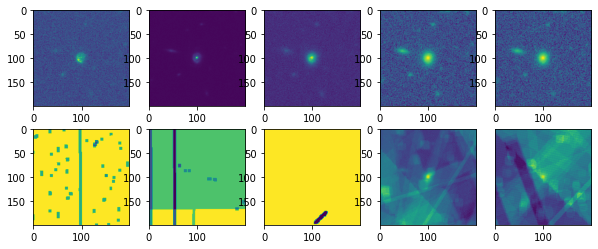

In [8]:
#testing preprocessing on one cutout
cutout = hf_1.get('005.246_' + str(0))
cutout = tf.constant(cutout)
#cutout = tf.expand_dims(cutout, axis = 0)

fig, axs = plt.subplots(2,5,figsize= [10,4])
for i in range(5):
    axs[0,i].imshow(cutout[...,i])
    axs[1,i].imshow(cutout[...,i+5])

plt.yticks([])
plt.show()

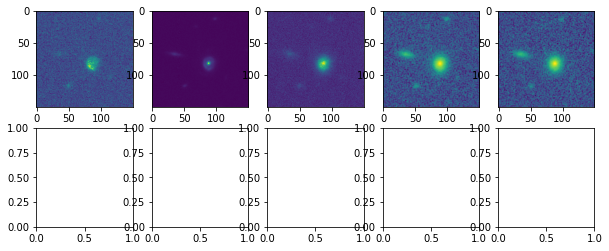

In [9]:
cutout = hf_1.get('005.246_' + str(0))
cutout = tf.constant(cutout)
#cutout = tf.expand_dims(cutout, axis = 0)
pre_cut = preprocess_image(cutout[...,:5])

fig, axs = plt.subplots(2,5,figsize= [10,4])
for i in range(5):
    axs[0,i].imshow(pre_cut[0][...,i])
    #axs[1,i].imshow(pre_cut[0][...,i+5])
plt.show()    

### on dataset

In [10]:
# #on multiple cutouts from numpy array
# arr = np.zeros((2000,200,200,10))
# keys = keys.sample(frac=1)
# i=0
# for key in keys[:2000]:
#     arr[i,...] = np.array(hf_1.get(key))
#     i +=1
    
# print(arr.shape)

# #img = next(iter(dataset.map(preprocess_image)))

In [11]:
#ds = tf.data.Dataset.from_tensor_slices(arr)

In [10]:
#trying out
class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        for im in self.file:
            yield self.file[im][...,:5]
                  
       
        #for im in range(len(arr)):
            #yield arr[im]

# ds = tf.data.Dataset.from_generator(
#     generator(scratch + 'Dataset_run2_1.h5',16), 
#     tf.float64, 
#     tf.TensorShape([16,150,150,5]))

#value = ds.make_one_shot_iterator().get_next()       
#next(iter(ds))  


#dataset = tf.data.Dataset.from_generator(generator(hf_1),  output_signature=(tf.TensorSpec(shape=(150,150,5), dtype=tf.float64),tf.TensorSpec(shape=(150,150,5), dtype=tf.float64)) )

In [11]:
gen = generator(hf_1)

In [12]:
dims = next(iter(gen())).shape

In [35]:
dims

TensorShape([150, 150, 5])

In [13]:
#dataset = tf.data.Dataset.from_generator(generator(hf_1),  output_signature=(tf.TensorSpec(shape=dims, dtype=tf.float64),tf.TensorSpec(shape=dims, dtype=tf.float64)) )
dataset = tf.data.Dataset.from_generator(generator(hf_1),  output_signature=(tf.TensorSpec(shape=dims, dtype=tf.float64)))

In [31]:
next(iter(dataset))

<tf.Tensor: shape=(150, 150, 5), dtype=float64, numpy=
array([[[-0.73664051,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 4.00058365,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 1.32551825,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [-0.60676396,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-4.61351109,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-3.23521996,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 4.52269316,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 4.44388151,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.08839971,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [ 4.22581816,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-1.90182424,  0.        ,  0.        ,  0.        ,
          0.    

In [94]:
ds = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [95]:
next(iter(ds))

(<tf.Tensor: shape=(150, 150, 5), dtype=float64, numpy=
 array([[[0.00202122, 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.00256871, 0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.00291771, 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.00301924, 0.        , 0.        , 0.        , 0.        ],
         [0.00268933, 0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.00281771, 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.00260049, 0.        , 0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , 0.        , 

In [52]:
#dataset i previously created
#tf.data.experimental.load('/home/anahoban/projects/rrg-kyi/astro/cfis/autoencoder_full_dataset_w')

## Training

In [15]:
myfile_on_disk=os.path.expandvars('$SLURM_TMPDIR')+ 'file.hdf5'
def prepare_dataset(dataset, batch_size):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID calculation
    return (
        dataset
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .shuffle(10 * batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [16]:
#whole data prep
BATCH_SIZE  = 16
dataset = prepare_dataset(dataset, BATCH_SIZE)

In [ ]:
next(iter(dataset))

In [17]:
n_train = 256
n_val = 128
#n_test = 0 
train = dataset.take(n_train)
val = dataset.skip(n_train).take(n_val)
#test = dataset.skip(n_train + n_val).take(n_test)

### Autoencoder


In [18]:
def create_autoencoder(shape):
    input_all = keras.Input(shape=shape)
    
    input_imgs = input_all
    x = keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(input_imgs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    y = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_imgs)
    y = keras.layers.BatchNormalization()(y)
    encoded = keras.layers.Add()([x,y])
    
    x = keras.layers.Conv2DTranspose(32, kernel_size=4, activation='relu', padding='same')(encoded)
    x = keras.layers.Conv2DTranspose(16, kernel_size=4, activation='relu', padding='same')(x)
    
    #weights
    decoded_img = keras.layers.Conv2D(shape[2], kernel_size=3, activation='linear', padding='same')(x)
    decoded_all = decoded_img#tf.concat([decoded_img, weights], axis = -1)
    
    #no weights
    #decoded_all = keras.layers.Conv2D(shape[2], kernel_size=3,activation='relu', padding = 'same')(x)                                  
    #set nan to 0 and flag it + counter
    return keras.Model(input_all, decoded_all)


In [19]:
##TRAINING PREP##
CUTOUT_SIZE = 150
N_EPOCHS    = 5


In [20]:
# model_checkpoint_file = "../Models/job13.h5"
# model_checkpoint_callback = ModelCheckpoint(model_checkpoint_file, monitor='val_loss', mode='min',verbose=1, save_best_only=True)

In [21]:
#training
autoencoder_cfis = create_autoencoder((CUTOUT_SIZE, CUTOUT_SIZE, 5)) #last is the number of channels
autoencoder_cfis.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

In [22]:
history = autoencoder_cfis.fit(train,
                        epochs=N_EPOCHS,
                        validation_data=val,
                               verbos = 2
#                         callbacks= all_callbacks
                              ) 


Epoch 1/5
256/256 [==============================] - 951s 3s/step - loss: 0.0215 - val_loss: 0.0087
Epoch 2/5
256/256 [==============================] - 601s 2s/step - loss: 0.0068 - val_loss: 0.0053
Epoch 3/5
256/256 [==============================] - 706s 2s/step - loss: 0.0047 - val_loss: 0.0051
Epoch 4/5
256/256 [==============================] - 674s 2s/step - loss: 0.0035 - val_loss: 0.0060
Epoch 5/5
256/256 [==============================] - 599s 2s/step - loss: 0.0034 - val_loss: 0.0101


In [ ]:
plot_loss_curves(history.history, 20, 'example batch 2')

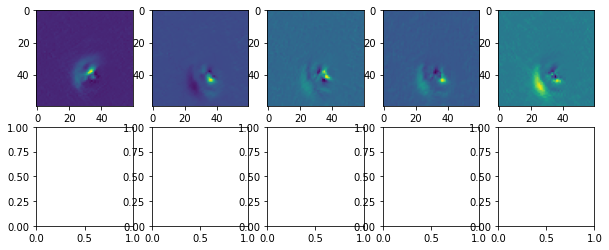

In [23]:
img = tf.image.random_crop(cutout, size = [150,150,10])[...,:5]
pred = autoencoder_cfis.predict(tf.expand_dims(img,axis = 0))

fig, axs = plt.subplots(2,5,figsize= [10,4])
for i in range(5):
    axs[0,i].imshow(pred[0,40:100,40:100,i])
    #axs[1,i].imshow(pred[0,...,i+5])
    
    
plt.show() #25 epochs